In [2]:
# Python 3.13.3

# Legendre basis with different test points

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.linalg import pinv, norm
from numpy.polynomial import legendre as lege

lege.legvander.__name__ = "Legendre"

rng = np.random.default_rng(seed=1728)

π = np.pi

interval = (-1.0, 1.0)

from matplotlib.ticker import FuncFormatter
plt.rcParams["savefig.bbox"] = 'tight'

# Formatting y axis as powers of 10
fmt = lambda x,pos: f'$10^{{{x:.0f}}}$'

In [4]:
def add_points(vander, point_type, N = 300,m=100):
    """ For basis of N functions total, with m functions in the model
    for each T from s to N, choose T points to be of type point_type

    parameters:
    -----------
    vander : callable
        Function that generates the Vandermonde matrix for 
        some basis and a given set of points
    point_type : str
        'lattice', 'random', 'cheblobatto', 'leggauss'
    N : int
        Total number of basis functions
    m : int     
        Number of functions in the model

    returns:
    --------
    A_norm : np.array
        log10 of the norms of A
    MTMinv_norm, MTU_norm : np.array
        log10 of the norms of MTM^+
    MTU_norm : np.array
        log10 of the norms of MTU

    """

    s = 4 # start from 4
    interval = (-1,1)

    # Initialize the norms
    A_norm = np.zeros(N-s)
    MTMinv_norm = np.zeros(N-s)
    MTU_norm = np.zeros(N-s)

    t = np.arange(s,N)
    for T in t:
        if point_type == 'lattice':
            pts = np.linspace(*interval, T)
        elif point_type == 'random':
            pts = rng.uniform(*interval, T)
        elif point_type == 'cheblobatto':
            pts = cheb.chebpts2(T)
        elif point_type == 'leggauss':
            pts = lege.leggauss(T)[0]
        else:
            raise ValueError("point_type must be 'lattice', 'random', 'cheblobatto', or 'leggauss'")
        
        M = vander(pts, N)
        MTM = M[:,:m]
        MTU = M[:,m:]
        try: 
            Minv = pinv(MTM)
            MTMinv_norm[T-s] = np.log10(norm(Minv))
            MTU_norm[T-s] = np.log10(norm(MTU))
            A_norm[T-s] = np.log10(norm(Minv @ MTU))

        except np.linalg.LinAlgError:
            MTMinv_norm[T-s] = np.nan
            MTU_norm[T-s] = np.nan
            A_norm[T-s] = np.nan

    return A_norm, MTMinv_norm, MTU_norm


In [5]:
lege.legvander.__name__ = "Legendre"
vanders = [lege.legvander]
pts = ['random', 'leggauss']
names = ['Random pts', 'Legendre-Gauss pts']

for v in vanders:
    for pt in pts[2:]:
        A_norm, MTMinv_norm, MTU_norm = add_points(v, pt,N=400)
        np.savez(v.__name__ + '_' + pt + '400.npz', A=A_norm, Minv=MTMinv_norm, U=MTU_norm)

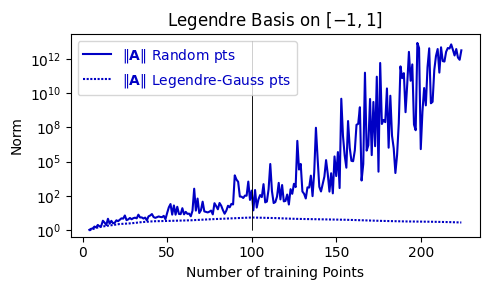

In [6]:
# Single combined plot 
pts = ['random', 'leggauss']
names = ['Random pts', 'Legendre-Gauss pts']
linestyles = ['solid',(0,(1,.75)) ]
v = lege.legvander
m = 100

red = (196/255, 0, 0)
green = (0, 96/255, 0)
blue = (0, 0, 196/255)

t = np.arange(4,225)
fig, ax = plt.subplots(1,1,figsize=(5,3))
for j, pt in enumerate(pts):
    with np.load(v.__name__ + '_' + pt + '2000.npz') as data:
        # ax.plot(t, data['U'][:len(t)], color='C2', linestyle = linestyles[j], label=r'$\|\mathbb{M}_{\mathscr{TU}}\|_2$')
        ax.plot(t, data['A'][:len(t)], color=blue,linestyle=linestyles[j],label=r"$\|\mathbf{A}\|$ "+names[j])
        # ax.plot(t, data['Minv'][:len(t)], color='C1', linestyle = linestyles[j], label=r'$\|\mathbb{M}_{\mathscr{TM}}^{+}\|_2$')

        if j == 1:
            ax.set_xlabel("Number of training Points")
            # ymin=0
            # ymax=2
            # ax.set_yticks(np.arange(0,3,1), [f'$10^{i}$' for i in range(3)])

        else:
            ymax = max(np.nanmax(data['A'][:len(t)]), np.nanmax(data['Minv'][:len(t)]), np.nanmax(data['U'][:len(t)]))
            ymin = min(np.nanmin(data['A'][:len(t)]), np.nanmin(data['Minv'][:len(t)]), np.nanmin(data['U'][:len(t)]))  
            ax.set_ylim(ymin-0.5, ymax+0.5)
            ax.yaxis.set_major_formatter(FuncFormatter(fmt))
        

        ax.vlines(m, ymin, ymax, color='k',lw=0.5)  

        ax.set_ylabel("Norm")

        if j == 0:
            ax.set_title(f"{v.__name__} Basis on $[-1,1]$")        
        
    ax.legend(labelcolor='linecolor', frameon=True)    
plt.tight_layout()
plt.savefig("adding_points_225.pdf", dpi=300, bbox_inches='tight')

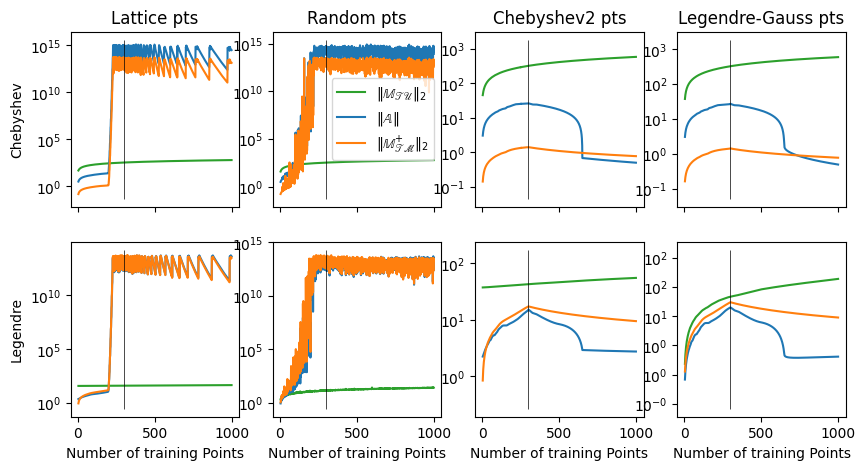

In [55]:

fig,axes = plt.subplots(2,4,figsize=(10,5), sharex=True, sharey=False)
for i,v in enumerate(vanders):
    for j, pt in enumerate(pts):
        with np.load(v.__name__ + '_' + pt + '.npz') as data:
            ax = axes[i,j]
            ax.plot(t, data['U'], color='C2', label=r'$\|\mathbb{M}_{\mathscr{TU}}\|_2$')
            ax.plot(t, data['A'], color='C0', label=r"$\|\mathbb{A}\|$")
            ax.plot(t, data['Minv'], color='C1', label=r'$\|\mathbb{M}_{\mathscr{TM}}^{+}\|_2$')

            ymax = max(np.nanmax(data['A']), np.nanmax(data['Minv']), np.nanmax(data['U'])) + 0.5
            ymin = min(np.nanmin(data['A']), np.nanmin(data['Minv']), np.nanmin(data['U'])) - 0.5    
            ax.yaxis.set_major_formatter(FuncFormatter(fmt))

            ax.vlines(m, ymin, ymax, color='k',lw=0.5)  

            if j == 0:
                ax.set_ylabel(f"{v.__name__}")

            if i == 0:
                ax.set_title(f"{names[j]}")        
                if j == 1:
                    ax.legend()
            
            if i == 1:
                ax.set_xlabel("Number of training Points")

plt.savefig("adding_points.pdf", dpi=300)

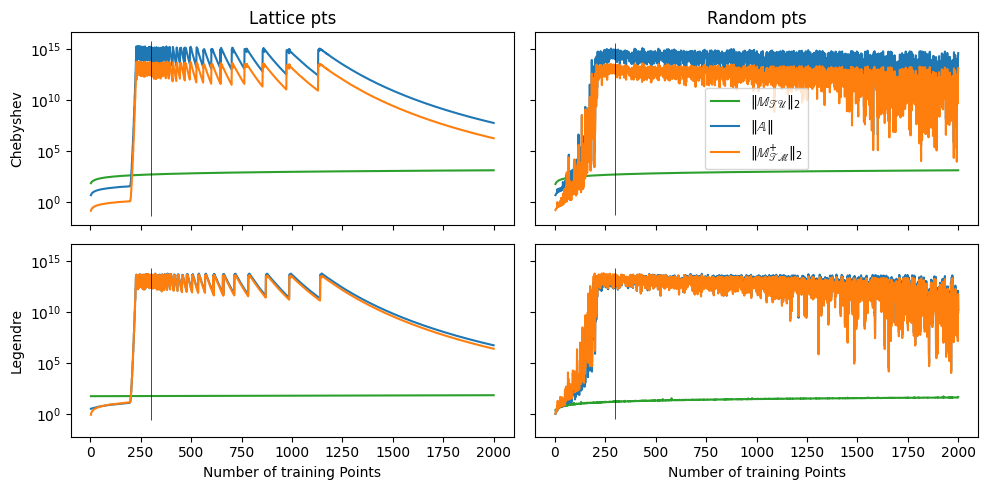

In [73]:
t = np.arange(4,2000)
fig,axes = plt.subplots(2,2,figsize=(10,5), sharex=True, sharey=True)
for i,v in enumerate(vanders):
    for j, pt in enumerate(pts[:2]):
        with np.load(v.__name__ + '_' + pt + '2000.npz') as data:
            ax = axes[i,j]
            ax.plot(t, data['U'], color='C2', label=r'$\|\mathbb{M}_{\mathscr{TU}}\|_2$')
            ax.plot(t, data['A'], color='C0', label=r"$\|\mathbb{A}\|$")
            ax.plot(t, data['Minv'], color='C1', label=r'$\|\mathbb{M}_{\mathscr{TM}}^{+}\|_2$')

            ymax = max(np.nanmax(data['A']), np.nanmax(data['Minv']), np.nanmax(data['U'])) + 0.5
            ymin = min(np.nanmin(data['A']), np.nanmin(data['Minv']), np.nanmin(data['U'])) - 0.5    
            ax.yaxis.set_major_formatter(FuncFormatter(fmt))

            ax.vlines(m, ymin, ymax, color='k',lw=0.5)  

            if j == 0:
                ax.set_ylabel(f"{v.__name__}")

            if i == 0:
                ax.set_title(f"{names[j]}")        
                if j == 1:
                    ax.legend()
            
            if i == 1:
                ax.set_xlabel("Number of training Points")
plt.tight_layout()
plt.savefig("adding_bad_points2000.pdf", dpi=300)

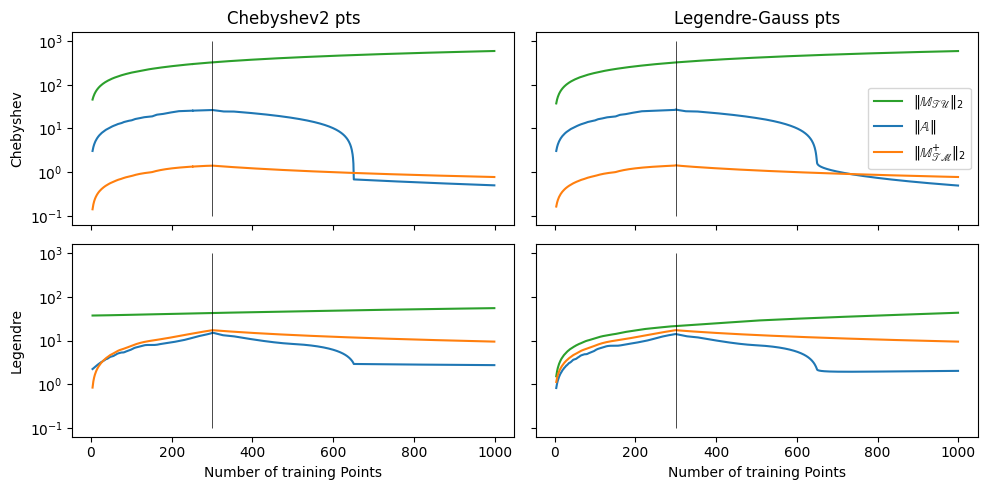

In [70]:
t = np.arange(4,1000)
fig,axes = plt.subplots(2,2,figsize=(10,5), sharex=True, sharey=True)
for i,v in enumerate(vanders):
    for j, pt in enumerate(pts[2:]):
        with np.load(v.__name__ + '_' + pt + '.npz') as data:
            ax = axes[i,j]
            ax.plot(t, data['U'], color='C2', label=r'$\|\mathbb{M}_{\mathscr{TU}}\|_2$')
            ax.plot(t, data['A'], color='C0', label=r"$\|\mathbb{A}\|$")
            ax.plot(t, data['Minv'], color='C1', label=r'$\|\mathbb{M}_{\mathscr{TM}}^{+}\|_2$')

            #ymax = max(np.nanmax(data['A']), np.nanmax(data['Minv']), np.nanmax(data['U'])) + 0.5
            #ymin = min(np.nanmin(data['A']), np.nanmin(data['Minv']), np.nanmin(data['U'])) - 0.5    
            ymin = -1
            ymax = 3
            ax.yaxis.set_major_formatter(FuncFormatter(fmt))

            ax.vlines(m, ymin, ymax, color='k',lw=0.5)  

            if j == 0:
                ax.set_ylabel(f"{v.__name__}")

            if i == 0:
                ax.set_title(f"{names[j+2]}")        
                if j == 1:
                    ax.legend()
            
            if i == 1:
            
                ax.set_xlabel("Number of training Points")
plt.tight_layout()
plt.savefig("adding_good_points.pdf", dpi=300)